# Sparse reduced-rank regression for exploratory visualization<br>of single cell patch-seq recordings

### *Dmitry Kobak, Marissa A. Weis, and Philipp Berens*

This notebook implements all the code for https://www.biorxiv.org/content/early/2018/04/XX/XXXXXX

Figures on white background are the ones included in the paper (main text or SI). Figures on gray background only exist in this notebook.

<img src="figure-rrr.png"  alt="Sparse reduced-rank regression for patch-seq data">

The loss function for reduced-rank regression with elastic net penalty:

$$\mathcal L = \lVert \mathbf Y - \mathbf X \mathbf W \mathbf V^\top\rVert^2 + \lambda_1 \sum_{i=1}^p\lVert \mathbf W_{i\cdot}\rVert_2 + \lambda_2 \lVert \mathbf W \rVert^2 \;\;\;\text{s.t.}\; \mathbf V^\top\mathbf V = \mathbf I.$$

In [1]:
# Load libraries and set up notebook

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
from scipy import io
import time
import pickle
import warnings

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams.update({'nbagg.transparent': False, 'figure.facecolor': 'white'})

import glmnet_python
from glmnet import glmnet

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

## Main functions are here. Scroll down for the dataset applications

In [2]:
###################################################
# Elastic net reduced-rank regression

def elastic_rrr(X, Y, rank=2, lambdau=1, alpha=0.5, max_iter = 100):
    # initialize with PLS direction
    _,_,v = np.linalg.svd(X.T @ Y, full_matrices=False)
    v = v[:rank,:].T
    
    loss = np.zeros(max_iter)
    
    for iter in range(max_iter):
        if rank == 1:
            w = glmnet(x = X.copy(), y = (Y @ v).copy(), alpha = alpha, lambdau = np.array([lambdau]), 
                       standardize = False, intr = False)['beta']
        else:
            w = glmnet(x = X.copy(), y = (Y @ v).copy(), alpha = alpha, lambdau = np.array([lambdau]), 
                       family = "mgaussian", standardize = False, intr = False,
                       standardize_resp = False)['beta']
            w = np.concatenate(w, axis=1)
                
        if np.all(w==0):
            v = v * 0
            return (w, v)
            
        A = Y.T @ X @ w
        a,c,b = np.linalg.svd(A, full_matrices = False)
        v = a @ b
        v = v * np.sign(np.sum(v, axis=0))
        
        loss[iter] = np.sum((Y - X @ w @ v.T)**2)/np.sum(Y**2);        
        
        if iter > 0 and np.abs(loss[iter]-loss[iter-1]) < 1e-6:
#             print('Converged in ' + str(iter) + ' iterations')
            break
#         if iter == max_iter-1:
#             print('Did not converge.', loss)
    
    return (w, v)


###################################################
# Double biplot function
def bibiplot(X, Y, w, v, 
             YdimsNames=np.array([]), YdimsToShow=np.array([]),
             XdimsNames=np.array([]), XdimsToShow=np.array([]), 
             titles=[], xylim = 3,
             cellTypes=np.array([]), cellTypeColors={}, cellTypeLabels={},
             figsize=(9,4), axes=None):
    
    # Project and standardize
    Zx = X @ w[:,:2]
    Zy = Y @ v[:,:2]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)
    
    if not axes:
        plt.figure(figsize=figsize)
        plt.subplot(121, aspect='equal')
    else:
        plt.sca(axes[0])
    
    if cellTypes.size == 0:
        plt.scatter(Zx[:,0], Zx[:,1])
    else:
        for u in np.unique(cellTypes):
            if not cellTypeLabels:
                plt.scatter(Zx[cellTypes==u,0], Zx[cellTypes==u,1], color=cellTypeColors[u])
            else:
                plt.scatter(Zx[cellTypes==u,0], Zx[cellTypes==u,1], color=cellTypeColors[u], label=cellTypeLabels[u])
    plt.xlim([-xylim,xylim])
    plt.ylim([-xylim,xylim])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    if titles:
        plt.title(titles[0])
    if cellTypeLabels:
        plt.legend(bbox_to_anchor=(1.27, 1.0))
        
    if XdimsToShow.size > 0:
        scaleFactor = 2
        L = np.corrcoef(np.concatenate((Zx[:,:2], X), axis=1), rowvar=False)[2:,:2]
        for i in XdimsToShow:
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=1, color=[.4, .4, .4])
            plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, XdimsNames[i], 
                     ha='center', va='center', color=[.4, .4, .4], fontsize=10)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=1)
        plt.gca().add_patch(circ)

    if not axes:
        plt.subplot(122, aspect='equal')
    else:
        if not axes[1]:
            return
        plt.sca(axes[1])
        
    if cellTypes.size == 0:
        plt.scatter(Zy[:,0], Zy[:,1])
    else:
        for u in np.unique(cellTypes):
            plt.scatter(Zy[cellTypes==u,0], Zy[cellTypes==u,1], color=cellTypeColors[u])
    plt.xlim([-xylim,xylim])
    plt.ylim([-xylim,xylim])
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    if titles:
        plt.title(titles[1])
    plt.tight_layout()

    if YdimsToShow.size > 0:
        scaleFactor = 2
        L = np.corrcoef(np.concatenate((Zy[:,:2], Y), axis=1), rowvar=False)[2:,:2]
        for i in YdimsToShow:
            plt.plot([0, scaleFactor*L[i,0]], [0, scaleFactor*L[i,1]], linewidth=1, color=[.4, .4, .4])
            plt.text(scaleFactor*L[i,0]*1.2, scaleFactor*L[i,1]*1.2, YdimsNames[i], 
                     ha='center', va='center', color=[.4, .4, .4], fontsize=10)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=1)
        plt.gca().add_patch(circ)
        
        
###################################################
# Permutation procedures to estimate dimensionality
def dimensionality(X, Y, nrep = 100, seed = 42, axes=None, figsize=(9,3)):

    np.random.seed(seed)

    _,spectrum,_ = np.linalg.svd(X, full_matrices=False)
    spectra = np.zeros((nrep, spectrum.size))
    for rep in range(nrep):
        Xperm = X.copy()
        for i in range(Xperm.shape[1]):
            Xperm[:,i] = Xperm[:,i][np.random.permutation(Xperm.shape[0])]
        _, spectra[rep,:], _ = np.linalg.svd(Xperm, full_matrices=False)
    
    if not axes:
        plt.figure(figsize=figsize)
        plt.subplot(131)
    else:
        plt.sca(axes[0])
    plt.plot(np.arange(1, spectrum.size), spectra[:,:-1].T**2/np.sum(spectrum**2), 'k', linewidth=1)
    plt.plot(np.arange(1, spectrum.size), spectrum[:-1]**2/np.sum(spectrum**2), '.-')
    dimX = np.where(spectrum < np.percentile(spectra, 95, axis=0))[0][0]
    plt.text(plt.xlim()[1]*.2, plt.ylim()[1]*.8, 'X dimensionality: ' + str(dimX), fontsize=10)

    _,spectrum,_ = np.linalg.svd(Y, full_matrices=False)
    spectra = np.zeros((nrep, spectrum.size))
    for rep in range(nrep):
        Xperm = Y.copy()
        for i in range(Xperm.shape[1]):
            Xperm[:,i] = Xperm[:,i][np.random.permutation(Xperm.shape[0])]
        _, spectra[rep,:], _ = np.linalg.svd(Xperm, full_matrices=False)

    showy = True
    if not axes:
        plt.subplot(132)
    else:
        if axes[1]:
            plt.sca(axes[1])
        else:
            showy = False
    if showy:
        plt.plot(np.arange(1, spectrum.size), spectra[:,:-1].T**2/np.sum(spectrum**2), 'k', linewidth=1)
        plt.plot(np.arange(1, spectrum.size), spectrum[:-1]**2/np.sum(spectrum**2), '.-')
        dimY = np.where(spectrum < np.percentile(spectra, 95, axis=0))[0][0]
        plt.text(plt.xlim()[1]*.2, plt.ylim()[1]*.8, 'Y dimensionality: ' + str(dimY), fontsize=10)

    Xz,_,_ = np.linalg.svd(X, full_matrices=False)
    Xz = Xz[:,:dimX]
    yhat = Xz @ Xz.T @ Y
    _,spectrum,_ = np.linalg.svd(yhat, full_matrices=False)
    spectra = np.zeros((nrep, spectrum.size))
    for rep in range(nrep):
        Xz = Xz[np.random.permutation(Xz.shape[0]),:]
        yhat = Xz @ Xz.T @ Y
        _, spectra[rep,:], _ = np.linalg.svd(yhat, full_matrices=False)
    
    if not axes:
        plt.subplot(133)
    else:
        plt.sca(axes[2])
    p = min(dimX, Y.shape[1])
    plt.plot(np.arange(1, p+1), spectra[:,:p].T**2/np.sum(spectrum**2), 'k', linewidth=1)
    plt.plot(np.arange(1, p+1), spectrum[:p]**2/np.sum(spectrum**2), '.-')
    dimRRR = np.where(spectrum < np.percentile(spectra, 95, axis=0))[0][0]
    plt.text(plt.xlim()[1]*.2, plt.ylim()[1]*.8, 'RRR dimensionality: ' + str(dimRRR), fontsize=10)

    plt.tight_layout()

    
###################################################
# Cross-validation for elastic net reduced-rank regression
def elastic_rrr_cv(X, Y, alphas = np.array([.2, .5, .9]), lambdas = np.array([.01, .1, 1]), 
                   reps=10, folds=10, rank=1, seed=42):
    n = X.shape[0]
    r2 = np.zeros((folds, reps, len(lambdas), len(alphas)))
    r2_relaxed = np.zeros((folds, reps, len(lambdas), len(alphas)))
    corrs = np.zeros((folds, reps, len(lambdas), len(alphas), rank))
    corrs_relaxed = np.zeros((folds, reps, len(lambdas), len(alphas), rank))
    nonzero = np.zeros((folds, reps, len(lambdas), len(alphas)))

    # CV repetitions
    np.random.seed(seed)
    t = time.time()
    for rep in range(reps):
        print(rep+1, end='')
        ind = np.random.permutation(n)
        X = X[ind,:]
        Y = Y[ind,:]
        
        # CV folds
        for cvfold in range(folds):
            print('.', end='')

            indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
            indtrain = np.setdiff1d(np.arange(n), indtest)
            Xtrain = np.copy(X[indtrain,:])
            Ytrain = np.copy(Y[indtrain,:])
            Xtest  = np.copy(X[indtest,:])
            Ytest  = np.copy(Y[indtest,:])
            
            # mean centering
            X_mean = np.mean(Xtrain, axis=0)
            Xtrain -= X_mean
            Xtest  -= X_mean
            Y_mean = np.mean(Ytrain, axis=0)
            Ytrain -= Y_mean
            Ytest  -= Y_mean
            
            # loop over regularization parameters
            for i,a in enumerate(lambdas):    
                for j,b in enumerate(alphas):
                    vx,vy = elastic_rrr(Xtrain, Ytrain, lambdau=a, alpha=b, rank=rank)
                    
                    if np.sum(vx[:,0]!=0) <= 1:
                        nonzero[cvfold, rep, i, j] = np.nan
                        continue
                    
                    nonzero[cvfold, rep, i, j] = np.sum(vx[:,0]!=0)
                    r2[cvfold, rep, i, j] = 1 - np.sum((Ytest - Xtest @ vx @ vy.T)**2) / np.sum(Ytest**2)
                    for r in range(rank):
                        corrs[cvfold, rep, i, j, r] = np.corrcoef(Xtest @ vx[:,r], Ytest @ vy[:,r], rowvar=False)[0,1]
                        
                    # Relaxation
                    vx[vx[:,0]!=0,:],vy = elastic_rrr(Xtrain[:,vx[:,0]!=0], Ytrain, lambdau=a, alpha=0, rank=rank)
                    r2_relaxed[cvfold, rep, i, j] = 1 - np.sum((Ytest - Xtest @ vx @ vy.T)**2) / np.sum(Ytest**2)
                    for r in range(rank):
                        corrs_relaxed[cvfold, rep, i, j, r] = np.corrcoef(Xtest @ vx[:,r], Ytest @ vy[:,r], rowvar=False)[0,1]
                    
        print(' ', end='')
    
    t = time.time() - t
    m,s = divmod(t, 60)
    h,m = divmod(m, 60)
    print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))
    
    return r2, r2_relaxed, nonzero, corrs, corrs_relaxed


###################################################
# Bootstrap selection for elastic net reduced-rank regression
def elastic_rrr_bootstrap(X, Y, rank=1, lambdau = 1.5, alpha = .5, nrep = 100, seed=42):
    np.random.seed(seed)
    ww = np.zeros((X.shape[1], nrep))
    for rep in range(nrep):
        print('.', end='')
        n = np.random.choice(X.shape[0], size = X.shape[0])
        w,v = elastic_rrr(X[n,:], Y[n,:], rank = rank, lambdau = lambdau, alpha = alpha)
        ww[:,rep] = w[:,0]
    print(' ')
    bootCounts = np.sum(ww!=0, axis=1)/nrep
    return bootCounts

## Cadwell et al. dataset

In [3]:
# LOAD ALL THE DATA FROM THE ORIGINAL FILES

# Read RPKM values
rpkm = pd.read_excel('cadwellData/Data_CortexInterneurons.xlsx', sheetname="rpkm")
rpkm = rpkm.drop(rpkm.columns[[0]], axis=1)
rpkm = rpkm.drop(rpkm.index[[0,1,3]])
rpkm.columns = rpkm.iloc[0]
rpkm = rpkm.drop(rpkm.index[[0]])
rpkm = rpkm.rename(columns={'Sandberg lab cell name:': 'Gene'})
rpkm = rpkm.set_index('Gene')
rpkm.columns.name = ''

# Read the list of most variable genes and re-sort the genes in the RPKM table in the same order
varGenes = pd.read_excel('https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3445-S3.xlsx')
varGenes = varGenes.drop(varGenes.columns[[0]], axis=1)
varGenes = varGenes.drop(varGenes.index[[0,1,2]])
varGenes = varGenes.rename(columns={'Unnamed: 1': 'Gene'})
varGenes = varGenes['Gene'].tolist()
#restGenes = [a for a in (set(rpkm.index) - set(varGenes))]# if a[1:5] != 'ERCC']
rpkm = rpkm.reindex(varGenes)#+restGenes)
geneNames = np.array([g[1:-1] for g in varGenes])#rpkm.index.tolist()])

# Read the annotated list of cells and select the ones to use
#   58 cells overall. Select 53 interneurons. 
#   2 cells (Int_44 and Int_45) additionally excluded based on personal communication with Athanasia: 
#   'we excluded them because we were afraid that they might be contaminated interneurons'
cells = pd.read_excel('https://media.nature.com/original/nature-assets/nbt/journal/v34/n2/extref/nbt.3445-S2.xlsx',
                      sheetname="Genes detected per cell")
cells = cells.drop(cells.columns[[0,3]], axis=1)
cells = cells.drop(cells.index[[0,1,2,3,62,63,64]])
cells = cells.rename(columns={'Unnamed: 1': 'Code', 'Unnamed: 2': 'Type'})
cells.index = range(len(cells))
goodCells = cells.loc[cells['Type'].str.startswith('L1 Int')]['Code'].tolist() 
goodCells = [c for c in goodCells if c[-2:]!='44' and c[-2:]!='45']
goodCells = ["'" + c[0:3] + "_" + c[4:] + "'" for c in goodCells]
badCells = [c for c in rpkm.columns.tolist() if (c not in goodCells and c != 'Gene')]
rpkm = rpkm.drop(badCells, axis=1)
X_rpkm = rpkm.values.astype(np.float).T

# Read ephys properties and expert classification of interneuron type based on the ephys properties
# 1 - definitely one type, 5 - definitely another type
# nans correspond to 5 cells recorded in vivo for which ephys was too confusing
mat = io.loadmat('cadwellData/IntPhysiologyFinal.mat')
n = len(mat['cell'][0])

types = [mat['cell'][0][n][3][0][0] for n in range(n)]
types = np.asarray(types)
idxs  = [mat['cell'][0][n][0][0][0] for n in range(n)]
idxs = np.asarray(idxs)

cols = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
ephysProperties = ['V_rest', 'R_input', 'AP tau', 'AP thresh', 'AP width', 'AP amp', 'AHP', 'ADP', 
                   'Adapt', 'ifDelayed', 'ifBurst']
ephys = np.zeros((n, len(cols)))
for j,c in enumerate(cols):
    ephys[:,j] = [mat['cell'][0][i][c][0][0] for i in range(n)]

cellTypes = np.zeros(len(goodCells))
ephysData = np.zeros((len(goodCells), len(cols)))

for i in range(len(goodCells)):
    lookup = np.where(idxs == int(goodCells[i][5:-1]))[0]
    if len(lookup)==0:
        cellTypes[i] = np.nan
        ephysData[i,:] = np.nan
    else:
        cellTypes[i] = types[lookup[0]]
        ephysData[i,:] = ephys[lookup[0],:]

# Double-check
print('RPKM shape:', X_rpkm.shape)
print('ephys shape:', ephysData.shape)
print('cellTypes shape:', cellTypes.shape)
print('ephys properties:', ', '.join(ephysProperties))
print('genes:', ', '.join(geneNames[:10]), '...')

RPKM shape: (51, 15074)
ephys shape: (51, 11)
cellTypes shape: (51,)
ephys properties: V_rest, R_input, AP tau, AP thresh, AP width, AP amp, AHP, ADP, Adapt, ifDelayed, ifBurst
genes: Tac2, Mbp, Penk, Npy, Sparc, Sln, Cxcl14, Egr4, Cacng5, Npy2r ...


In [22]:
# PREPROCESSING PIPELINE

# Library size normalization
X = X_rpkm / np.sum(X_rpkm, axis=1, keepdims=True) * np.median(np.sum(X_rpkm, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the ephys data
ind = ~np.isnan(np.sum(ephysData, axis=1))
X = X[ind, :]
Y = ephysData[ind, :]
cellTypes = cellTypes[ind]

# Sort out genes that are constant zero for the remaining cells
geneNames = geneNames[np.sum(X, axis=0)>0]
X = X[:, np.sum(X, axis=0)>0]

# Standardize X
mu = np.mean(X, axis=0)
X = X - mu
Xnst = X[:,:3000]
sigma = np.std(X, axis=0)
X = X / sigma

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

# Select 3k most variable genes (the ones identified in the Cadwell et al. paper)
Xall = X.copy()
X = X[:,:3000]
geneNamesAll = geneNames.copy()
geneNames = geneNames[:3000]

print('Xall.shape:', Xall.shape)
print('X.shape:', X.shape)
print('Y.shape:', Y.shape)
print('Unambiguously classified cells:', np.sum((cellTypes==1) | (cellTypes==5)))

Xall.shape: (44, 15054)
X.shape: (44, 3000)
Y.shape: (44, 11)
Unambiguously classified cells: 35


In [23]:
# Plotting parameters for Cadwell data

colors = np.zeros((5,3))
colors[0,:] = [217,95,2]
colors[-1,:] = [27,158,119]
for i in range(1,4):
    colors[i,:] = colors[0,:] * (5-i)/4 + colors[-1,:] * i/4
colors = colors/256

cellTypeColors = dict(zip(range(1,6), colors))
cellTypeLabels = dict(zip(range(1,6), ['SBC', None, None, None,'eNGC']))

PC1 correlation: 0.74
PC2 correlation: 0.22
PC3 correlation: 0.17
PC4 correlation: 0.29
PC5 correlation: 0.02


<IPython.core.display.Javascript object>


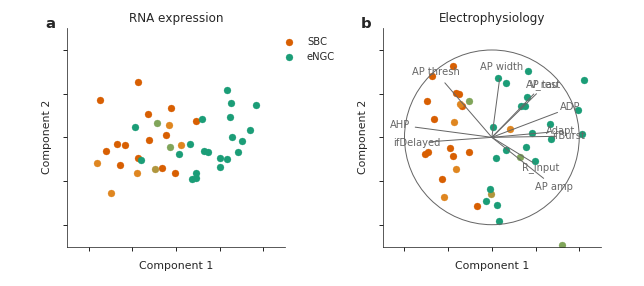

In [24]:
# PCA

# PCA of Y, and fix the signs such that sums of eigenvector elements are always positive
uy,sy,vy = np.linalg.svd(Y, full_matrices=False)
vy = vy.T
uy = uy * np.sign(np.sum(vy, axis=0))
vy = vy * np.sign(np.sum(vy, axis=0))

# PCA of X, and fix the signs such that correlations between PCi in X and Y are always positive
ux,sx,vx = np.linalg.svd(X, full_matrices=False)
vx = vx.T
for i in range(5):
    vx[:,i] = vx[:,i] * np.sign(np.corrcoef(ux[:,i],uy[:,i],rowvar=False)[0,1])
    print('PC{} correlation: {:0.2f}'.format(i+1, np.abs(np.corrcoef(ux[:,i],uy[:,i],rowvar=False)[0,1])))

sns_styleset()
bibiplot(X, Y, vx, vy, titles=['RNA expression', 'Electrophysiology'], 
         cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephysProperties, YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         xylim = 2.5)
sns.despine()

plt.text(-.1, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/figure-cadwell-pca.pdf')

<IPython.core.display.Javascript object>


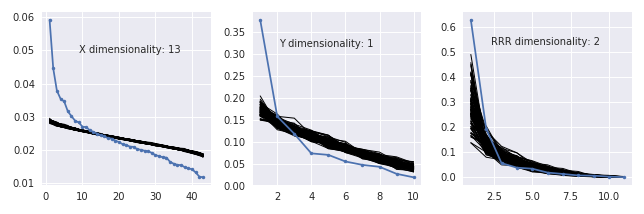

In [25]:
sns.set()
dimensionality(X, Y)

<IPython.core.display.Javascript object>


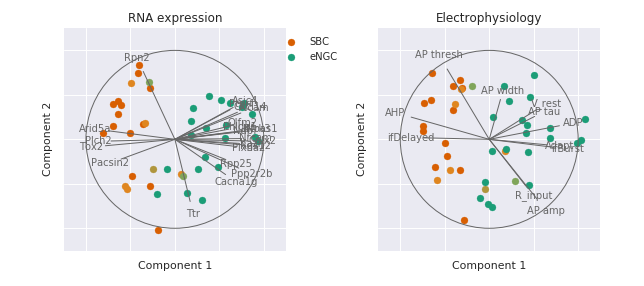

In [26]:
# RRR example

w,v = elastic_rrr(X, Y, rank=2, alpha = .5, lambdau = 1.5)
w[w[:,0]!=0,:],v = elastic_rrr(X[:,w[:,0]!=0], Y, lambdau = 1.5, alpha=0, rank=2)

sns.set()
bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'],
         cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephysProperties, YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNames, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5)

In [9]:
# Cross-validation to select lambda and alpha

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])
alphas = [.2, .5, .7, .9]

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = elastic_rrr_cv(X, Y, 
        lambdas=lambdas, alphas=alphas, reps=100, rank=2, folds=11)

with open('cv_cadwell.pickle', 'wb') as f:
    pickle.dump([r2, r2_relaxed, nonzeros, corrs, corrs_relaxed], f)

1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... 11........... 12........... 13........... 14........... 15........... 16........... 17........... 18........... 19........... 20........... 21........... 22........... 23........... 24........... 25........... 26........... 27........... 28........... 29........... 30........... 31........... 32........... 33........... 34........... 35........... 36........... 37........... 38........... 39........... 40........... 41........... 42........... 43........... 44........... 45........... 46........... 47........... 48........... 49........... 50........... 51........... 52........... 53........... 54........... 55........... 56........... 57........... 58........... 59........... 60........... 61........... 62........... 63........... 64........... 65........... 66........... 67........... 68........... 69........... 70........... 71........... 72........... 7

<IPython.core.display.Javascript object>


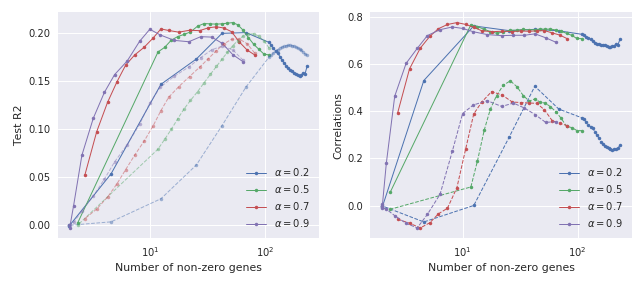

In [27]:
def plot_cv_results(filename):
    with open(filename, 'rb') as f:
        r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = pickle.load(f)
    
    # suppressing "mean of empty slice" warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        n = np.nanmean(nonzeros, axis=(0,1))
        cr = np.nanmean(r2_relaxed, axis=(0,1))
        c = np.nanmean(r2, axis=(0,1))
        c1 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,0]
        c2 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,1]

    sns.set()
    plt.figure(figsize=(9,4))
    plt.subplot(121)
    plt.plot(n, cr, '.-', linewidth=1)
    plt.gca().set_prop_cycle(None)
    plt.plot(n, c, '.--', linewidth=1, alpha=.5)
    plt.xscale('log')
    plt.xlabel('Number of non-zero genes')
    plt.ylabel('Test R2')
    plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])

    plt.subplot(122)
    plt.plot(n, c1, '.-', linewidth=1)
    plt.gca().set_prop_cycle(None)
    plt.plot(n, c2, '.--', linewidth=1)
    plt.xscale('log')
    plt.xlabel('Number of non-zero genes')
    plt.ylabel('Correlations')
    plt.legend(alphas)
    plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
    plt.tight_layout()

plot_cv_results('cv_cadwell.pickle')

<IPython.core.display.Javascript object>


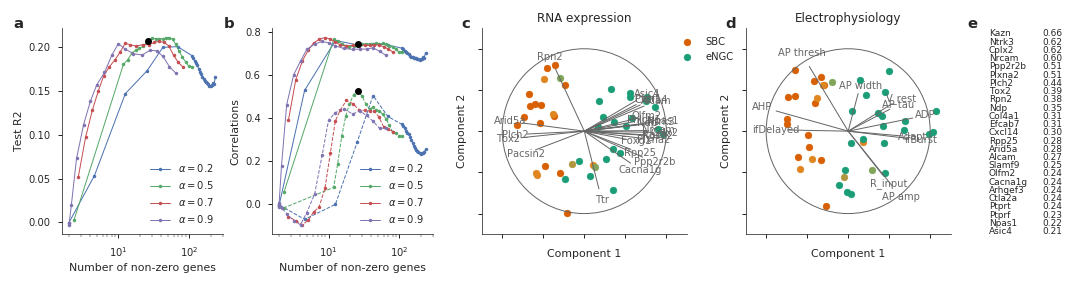

.................................................................................................... 


In [28]:
with open('cv_cadwell.pickle', 'rb') as f:
    r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = pickle.load(f)
    
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    c = np.nanmean(r2_relaxed, axis=(0,1))
    n = np.nanmean(nonzeros, axis=(0,1))
    c1 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,0]
    c2 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,1]
    
sns_styleset()
plt.figure(figsize=(15,4))

ax1 = plt.subplot(141)
plt.plot(n, c, '.-', linewidth=1)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test R2')
plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n[np.isclose(lambdas,1.4), np.array(alphas)==.5], 
         c[np.isclose(lambdas,1.4), np.array(alphas)==.5], 'ko')

ax2 = plt.subplot(142)
plt.plot(n, c1, '.-', linewidth=1)
plt.gca().set_prop_cycle(None)
plt.plot(n, c2, '.--', linewidth=1)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Correlations')
plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n[np.isclose(lambdas,1.4), np.array(alphas)==.5], 
         c1[np.isclose(lambdas,1.4), np.array(alphas)==.5], 'ko')
plt.plot(n[np.isclose(lambdas,1.4), np.array(alphas)==.5], 
         c2[np.isclose(lambdas,1.4), np.array(alphas)==.5], 'ko')

w,v = elastic_rrr(X, Y, rank=2, alpha = .5, lambdau = 1.4)
w[w[:,0]!=0,:],v = elastic_rrr(X[:,w[:,0]!=0], Y, lambdau = 1.4, alpha=0, rank=2)

ax3 = plt.subplot(143)
ax4 = plt.subplot(144)

bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephysProperties, YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNames, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5, axes=(ax3, ax4))

sns.despine()
plt.tight_layout()

pos = ax1.get_position()
ax1.set_position((pos.x0, pos.y0, .15, pos.height))
pos = ax2.get_position()
ax2.set_position((pos.x0 - .05, pos.y0, .15, pos.height))
pos = ax3.get_position()
ax3.set_position((pos.x0 - .1, pos.y0, pos.width, pos.height))
pos = ax4.get_position()
ax4.set_position((pos.x0 - .1, pos.y0, pos.width, pos.height))

bootCounts = elastic_rrr_bootstrap(X, Y, rank=2, lambdau = 1.5, alpha = .5)
i = np.argsort(bootCounts)[::-1]
   
with sns.axes_style('white'):
    ax5 = plt.axes((.92, pos.y0, .1, pos.height))
    
    for n, ii in enumerate(i[:25]):
        plt.text(0, 1-(n+1)/25, geneNames[ii], fontsize=9)
        plt.text(0.5, 1-(n+1)/25, '{:.2f}'.format(bootCounts[ii]), fontsize=9)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    sns.despine(ax=ax5, left=True, bottom=True)
    
plt.text(-.3, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.3, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=15, fontweight='bold')
plt.text(-.2, 1, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/figure-cadwell.pdf')

<IPython.core.display.Javascript object>


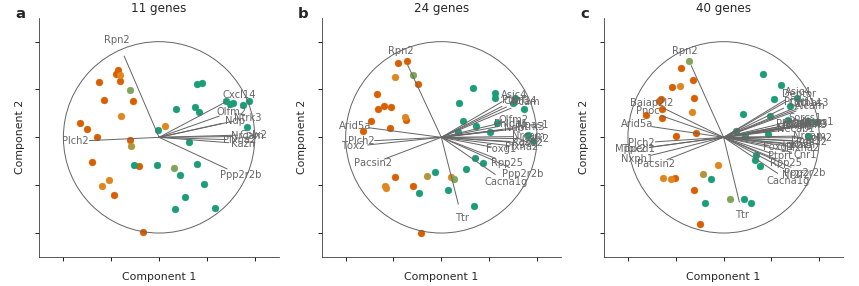

11 non-zero genes: ['Cxcl14' 'Cplx2' 'Plch2' 'Olfm2' 'Ndp' 'Ppp2r2b' 'Ntrk3' 'Kazn' 'Nrcam'
 'Rpn2' 'Plxna2']
24 non-zero genes: ['Cxcl14' 'Arid5a' 'Cplx2' 'Ptprf' 'Npas1' 'Plch2' 'Ttr' 'Rgs12' 'Pacsin2'
 'Alcam' 'Tox2' 'Olfm2' 'Asic4' 'Cacna1g' 'Ndp' 'Ppp2r2b' 'Ntrk3' 'Foxg1'
 'Kazn' 'Nrcam' 'Rpp25' 'Phlda1' 'Rpn2' 'Plxna2']
40 non-zero genes: ['Cxcl14' 'Arid5a' 'Egln3' 'Cplx2' 'Ptprf' 'Npas1' 'Plch2' 'Pnoc' 'Cnr1'
 'Ttr' 'Rgs12' 'Pacsin2' 'Deptor' 'Nxph1' 'Mpped1' 'Alcam' 'Sorcs1' 'Tox2'
 'Olfm2' 'Npas3' 'Asic4' 'Ptprt' 'Dnm3' 'Baiap2l2' 'Nr2f2' 'Cacna1g' 'Ndp'
 'Ppp2r2b' 'Ntrk3' 'Necab1' 'Foxg1' 'Trpm3' 'Kazn' 'Nrcam' 'Nrxn1' 'Rpp25'
 'Phlda1' 'Cdh18' 'Rpn2' 'Plxna2']


In [29]:
sns_styleset()
plt.figure(figsize=(12,4))
params = ((.9,.9), (.5, 1.4), (.2, 4))   # first alpha then lambda

ax = []
for i in range(len(params)):
    ax.append(plt.subplot(1, len(params), i+1, aspect='equal'))

for i in range(len(params)):
    w,v = elastic_rrr(X, Y, rank=2, alpha = params[i][0], lambdau = params[i][1])
    num = np.sum(w[:,0]!=0)
    print(num, 'non-zero genes:', geneNames[w[:,0]!=0])
    w[w[:,0]!=0,:],v = elastic_rrr(X[:,w[:,0]!=0], Y, lambdau = params[i][1], alpha=0, rank=2)

    bibiplot(X, Y, w, v, titles=['{} genes'.format(num), 'ePhys'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephysProperties, YdimsToShow=np.arange(Y.shape[1]),
         XdimsNames=geneNames, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5, axes=(ax[i], None))

sns.despine()
plt.tight_layout()

plt.text(-.1, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/figure-cadwell-varnumgenes.pdf')

In [13]:
# Comparing selected genes

# RRR excluding Rpn2 and Ttr
set1 = ['Cxcl14', 'Arid5a', 'Cplx2', 'Ptprf', 'Npas1', 'Plch2', 'Rgs12', 'Pacsin2',
 'Alcam', 'Tox2', 'Olfm2', 'Asic4', 'Cacna1g', 'Ndp', 'Ppp2r2b', 'Ntrk3', 'Foxg1', 'Kazn',
 'Nrcam', 'Rpp25', 'Phlda1', 'Plxna2'] 

# Cadwell et al. Figure 3, diff expressed genes between two clusters (not types!)
set2 = 'Arid5a Caln1 Tox2 Chst7 Car4 A830009L08Rik Baiap2l2 Npas1 Tac2 Cdh4 Cplx2 \
        Cdh18 Egln3 Rgs12 Dpp6 Npas3 Ntrk3 Alcam Syndig1 Klhl5 Sorcs1 Ptprf Lrrc75b Cxcl14'.split()

print(len(set1))
print(len(set2))
print(len(set(set1) & set(set2)))

22
24
9


In [14]:
# All genes

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = elastic_rrr_cv(Xall, Y, 
        lambdas=lambdas, alphas=alphas, reps=100, rank=2, folds=11)

with open('cv_cadwell_allgenes.pickle', 'wb') as f:
    pickle.dump([r2, r2_relaxed, nonzeros, corrs, corrs_relaxed], f)

1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... 11........... 12........... 13........... 14........... 15........... 16........... 17........... 18........... 19........... 20........... 21........... 22........... 23........... 24........... 25........... 26........... 27........... 28........... 29........... 30........... 31........... 32........... 33........... 34........... 35........... 36........... 37........... 38........... 39........... 40........... 41........... 42........... 43........... 44........... 45........... 46........... 47........... 48........... 49........... 50........... 51........... 52........... 53........... 54........... 55........... 56........... 57........... 58........... 59........... 60........... 61........... 62........... 63........... 64........... 65........... 66........... 67........... 68........... 69........... 70........... 71........... 72........... 7

<IPython.core.display.Javascript object>


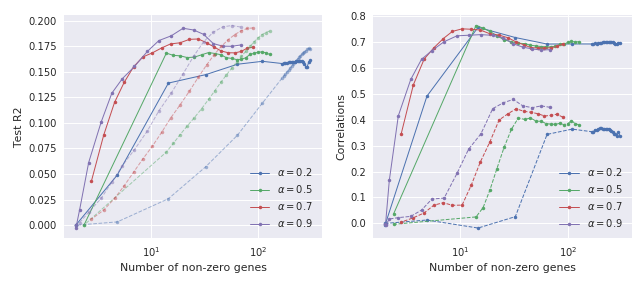

In [30]:
plot_cv_results('cv_cadwell_allgenes.pickle')

In [16]:
# Non-standardized genes

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = elastic_rrr_cv(Xnst, Y,
            lambdas=lambdas, alphas=alphas, reps=100, rank=2, folds=11)

with open('cv_cadwell_nonst.pickle', 'wb') as f:
    pickle.dump([r2, r2_relaxed, nonzeros, corrs, corrs_relaxed], f)    

1........... 2........... 3........... 4........... 5........... 6........... 7........... 8........... 9........... 10........... 11........... 12........... 13........... 14........... 15........... 16........... 17........... 18........... 19........... 20........... 21........... 22........... 23........... 24........... 25........... 26........... 27........... 28........... 29........... 30........... 31........... 32........... 33........... 34........... 35........... 36........... 37........... 38........... 39........... 40........... 41........... 42........... 43........... 44........... 45........... 46........... 47........... 48........... 49........... 50........... 51........... 52........... 53........... 54........... 55........... 56........... 57........... 58........... 59........... 60........... 61........... 62........... 63........... 64........... 65........... 66........... 67........... 68........... 69........... 70........... 71........... 72........... 7

<IPython.core.display.Javascript object>


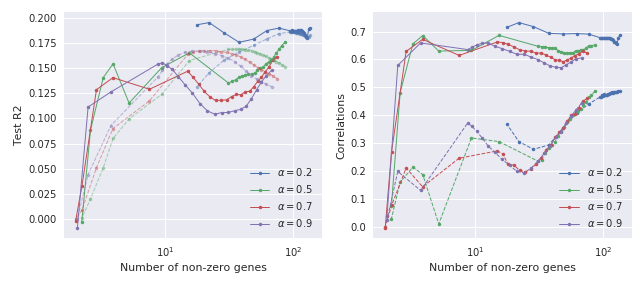

In [31]:
plot_cv_results('cv_cadwell_nonst.pickle')

22 non-zero genes: ['Cxcl14' 'Npas1' 'Pnoc' 'Ttr' 'Rgs12' 'Coro6' 'Sst' 'Nxph1' 'Dusp14'
 'Tox2' 'Eif2s3y' 'Asic4' 'Rhbdd3' 'Tspan17' 'Ppp2r2b' 'Ntrk3' 'Foxg1'
 'Kazn' 'Rpp25' 'Dtnbp1' 'Tmed3' 'Rpn2']


<IPython.core.display.Javascript object>


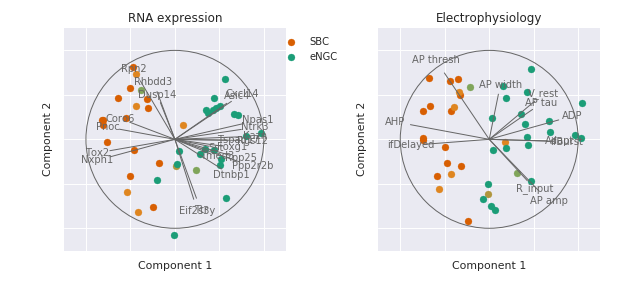

26 non-zero genes: ['Cxcl14' 'Arid5a' 'Cplx2' 'Npas1' 'Plch2' 'Ttr' 'Rgs12' 'Alcam' 'Tox2'
 'Olfm2' 'Asic4' 'Ndp' 'Ppp2r2b' 'Ntrk3' 'Kazn' 'Nrcam' 'Rpp25' 'Rpn2'
 'Plxna2' 'Naif1' 'Dnajc13' 'Elovl5' 'Ahr' 'Id4' '1810030O07Rik' 'Vstm2l']


<IPython.core.display.Javascript object>


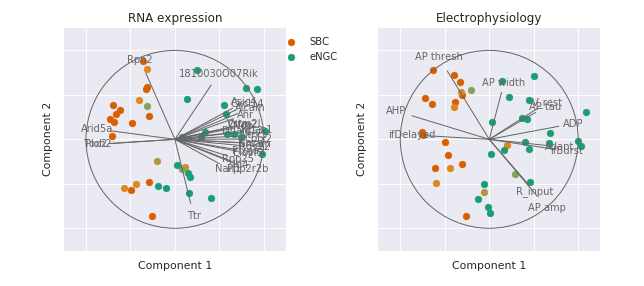

In [32]:
# Non-standardized data
w,v = elastic_rrr(Xnst, Y, rank=2, alpha = .5, lambdau = 2.5)
print(np.sum(w[:,0]!=0), 'non-zero genes:', geneNames[w[:,0]!=0])
w[w[:,0]!=0,:],v = elastic_rrr(Xnst[:,w[:,0]!=0], Y, lambdau=4, alpha=0, rank=2)

sns.set()
bibiplot(Xnst, Y, w, v, titles=['RNA expression', 'Electrophysiology'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephysProperties, YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNames, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5)

# All genes

w,v = elastic_rrr(Xall, Y, rank=2, alpha = .5, lambdau = 1.5)
print(np.sum(w[:,0]!=0), 'non-zero genes:', geneNamesAll[w[:,0]!=0])
w[w[:,0]!=0,:],v = elastic_rrr(Xall[:,w[:,0]!=0], Y, lambdau=1.5, alpha=0, rank=2)

bibiplot(Xall, Y, w, v, titles=['RNA expression', 'Electrophysiology'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=ephysProperties, YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNamesAll, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5)

# Fuzik et al. dataset

In [33]:
# Save Cadwell data for later
Xcadwell = X.copy()
Ycadwell = Y.copy()

In [34]:
# LOAD THE DATA FROM THE ORIGINAL FILES

from urllib.request import urlopen
from gzip import GzipFile

# Load gene counts from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE70844
url = 'ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE70nnn/GSE70844/suppl/GSE70844_Fuzik_et_al_molcounts.xls.gz'
molcounts = pd.read_excel(GzipFile(fileobj=urlopen(url)))
geneNames = np.array(list(molcounts.index))
cells = np.array(list(molcounts))
counts = molcounts.values.astype(np.float).T
ind = [i for i,g in enumerate(geneNames) if g[:5] != 'ERCC-']    # excluding spike ins
geneNames = geneNames[ind]
counts = counts[:,ind]
print('Count table size:', counts.shape)

# Load ephys data
ephys = pd.read_excel('fuzikData/Patch-Seq e-phys ALL.xlsx')
ephysProperties = list(ephys['run_label'][2:])
ephysProperties[18:35] = [a+' OneAP' for a in ephysProperties[18:35]]  # renaming repeated properties
ephysProperties[36:52] = [a+' CRamp' for a in ephysProperties[36:52]]
ephysProperties[53:66] = [a+' THR1' for a in ephysProperties[53:66]]
ephysProperties[67:80] = [a+' THR2' for a in ephysProperties[67:80]]
ephysProperties[81:] = [a+' THR3' for a in ephysProperties[81:]]
rowsExclude = [17, 35, 52, 66, 80]    # empty rows
rowsInclude = np.setdiff1d(np.arange(len(ephysProperties)), rowsExclude)
ephysProperties = np.array(ephysProperties)[rowsInclude]

cellTypes = np.array(ephys.values[1,1:])

ephys[ephys == '-'] = None
ephysData = ephys.values[2:,1:].astype('float')[rowsInclude,:].T
print('Ephys data size:', ephysData.shape)

# Matching gene counts to ephys data (thanks to Shreejoy Tripathy)
matching = pd.read_csv('fuzikData/ephys_expr_matching.csv')
cellsOrder = list(matching['expr_ids'])

print('Cells with sequence data but not matched to ephys:', 
      [c for i,c in enumerate(cells) if c not in cellsOrder])
ind = [i for i,c in enumerate(cells) if c in cellsOrder]
cells = cells[ind]
counts = counts[ind,:]
print('Number of matched cells:', len(ind))

ind = [cellsOrder.index(c) for c in cells]
ephysData = ephysData[ind,:]
cellTypes = cellTypes[ind]

ephysComplete = ~np.isnan(np.sum(ephysData, axis=0))
ephysData = ephysData[:,ephysComplete]
ephysProperties = ephysProperties[ephysComplete]
print('Number of ephys properties available for all cells:', np.sum(ephysComplete))

print('Counts shape:', counts.shape)
print('Ephys shape:', ephysData.shape)

Count table size: (83, 24378)
Ephys data size: (82, 89)
Cells with sequence data but not matched to ephys: ['Run283_L4_C01', 'Run291_L7_E10', 'Run291_L7_D12']
Number of matched cells: 80
Number of ephys properties available for all cells: 80
Counts shape: (80, 24378)
Ephys shape: (80, 80)


In [35]:
# PREPROCESSING PIPELINE

# Library size normalization
X = counts / np.sum(counts, axis=1, keepdims=True) * np.median(np.sum(counts, axis=1, keepdims=True))

# Log-transform
X = np.log2(X + 1)

# Sort out cells with nans in the ephys data
ind = ~np.isnan(np.sum(ephysData, axis=1))
X = X[ind, :]
Y = ephysData[ind, :]
cellTypes = cellTypes[ind]

# Sort out genes that are constant zero for the remaining cells
geneNames = geneNames[np.sum(X, axis=0)>0]
X = X[:, np.sum(X, axis=0)>0]

# Standardize X
muX = np.mean(X, axis=0)
X = X - muX
sigma = np.std(X, axis=0)
X = X / sigma

# Standardize Y
mu = np.mean(Y, axis=0)
Y = Y - mu
sigma = np.std(Y, axis=0)
Y = Y / sigma

print('X.shape before feature selection:', X.shape)

# Select genes
geneNames = geneNames[muX>.5]
X = X[:,muX>.5]

print('X.shape:', X.shape)
print('Y.shape:', Y.shape)

X.shape before feature selection: (80, 13089)
X.shape: (80, 1384)
Y.shape: (80, 80)


In [36]:
# Plotting parameters for Fuzik data

cellTypeColors = dict(zip(np.unique(cellTypes), 
                ['#6baed6', '#3182bd', '#08519c', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d', '#99000d']))
cellTypeLabels = dict(zip(np.unique(cellTypes), np.unique(cellTypes)))

PC1 correlation: 0.27
PC2 correlation: 0.47
PC3 correlation: 0.12
PC4 correlation: 0.11
PC5 correlation: 0.18


<IPython.core.display.Javascript object>


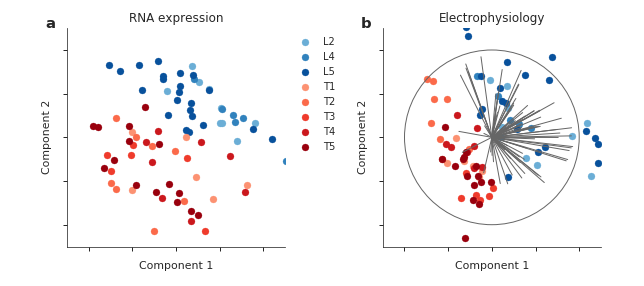

In [37]:
# PCA

# PCA of Y, and fix the signs such that sums of eigenvector elements are always positive
uy,sy,vy = np.linalg.svd(Y, full_matrices=False)
vy = vy.T
uy = uy * np.sign(np.sum(vy, axis=0))
vy = vy * np.sign(np.sum(vy, axis=0))

# PCA of X, and fix the signs such that correlations between PCi in X and Y are always positive
ux,sx,vx = np.linalg.svd(X, full_matrices=False)
vx = vx.T
for i in range(5):
    vx[:,i] = vx[:,i] * np.sign(np.corrcoef(ux[:,i],uy[:,i],rowvar=False)[0,1])
    print('PC{} correlation: {:0.2f}'.format(i+1, np.abs(np.corrcoef(ux[:,i],uy[:,i],rowvar=False)[0,1])))

sns_styleset()
bibiplot(X, Y, vx, vy, titles=['RNA expression', 'Electrophysiology'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
        YdimsNames=['' for i in ephysProperties], YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
        xylim = 2.5)
sns.despine()

plt.text(-.1, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/figure-fuzik-pca.pdf')

<IPython.core.display.Javascript object>


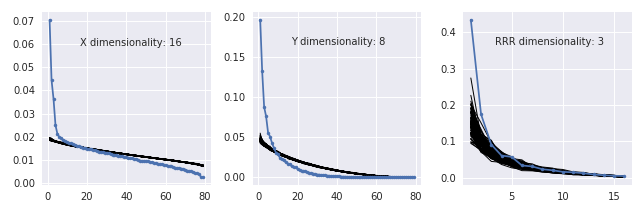

In [38]:
# Dimensionality estimates

sns.set()
dimensionality(X, Y)

<IPython.core.display.Javascript object>


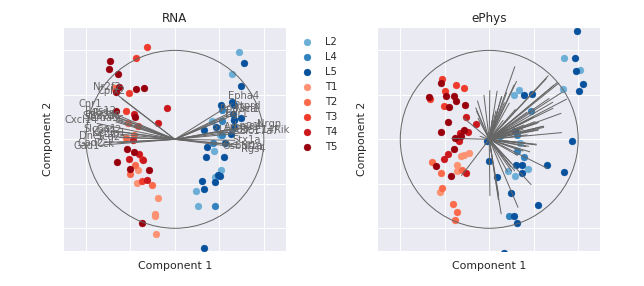

In [45]:
# Exemplary RRR

w,v = elastic_rrr(X, Y, rank=2, alpha = .2, lambdau = 8)
w[w[:,0]!=0,:],v = elastic_rrr(X[:,w[:,0]!=0], Y, lambdau = 8, alpha=0, rank=2)

sns.set()
bibiplot(X, Y, w, v, titles=['RNA', 'ePhys'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=['' for i in ephysProperties], YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNames, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5)

In [41]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])
alphas = [.2, .5, .7, .9]

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = elastic_rrr_cv(X, Y, 
        lambdas=lambdas, alphas=alphas, reps=100, rank=2, folds=10)

with open('cv_fuzik.pickle', 'wb') as f:
    pickle.dump([r2, r2_relaxed, nonzeros, corrs, corrs_relaxed], f)    

1.......... 2.......... 3.......... 4.......... 5.......... 6.......... 7.......... 8.......... 9.......... 10.......... 11.......... 12.......... 13.......... 14.......... 15.......... 16.......... 17.......... 18.......... 19.......... 20.......... 21.......... 22.......... 23.......... 24.......... 25.......... 26.......... 27.......... 28.......... 29.......... 30.......... 31.......... 32.......... 33.......... 34.......... 35.......... 36.......... 37.......... 38.......... 39.......... 40.......... 41.......... 42.......... 43.......... 44.......... 45.......... 46.......... 47.......... 48.......... 49.......... 50.......... 51.......... 52.......... 53.......... 54.......... 55.......... 56.......... 57.......... 58.......... 59.......... 60.......... 61.......... 62.......... 63.......... 64.......... 65.......... 66.......... 67.......... 68.......... 69.......... 70.......... 71.......... 72.......... 73.......... 74.......... 75.......... 76.......... 77.......... 78......

<IPython.core.display.Javascript object>


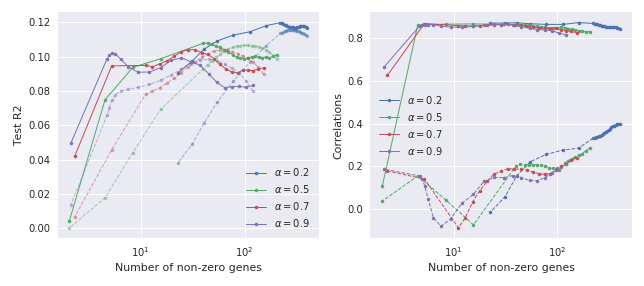

In [42]:
plot_cv_results('cv_fuzik.pickle')

<IPython.core.display.Javascript object>


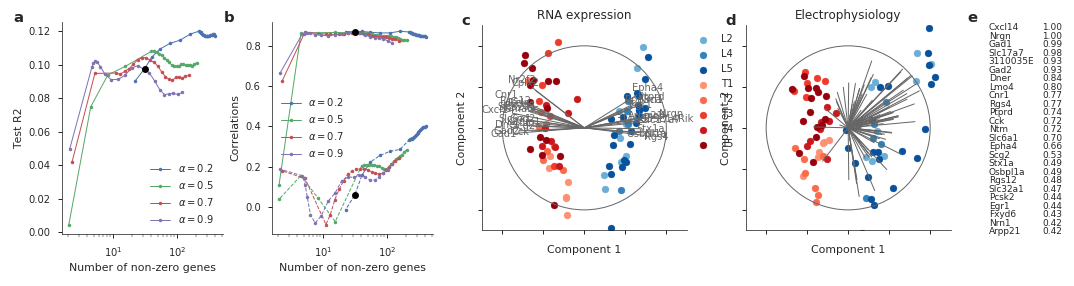

.................................................................................................... 


In [43]:
with open('cv_fuzik.pickle', 'rb') as f:
    r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = pickle.load(f)
    
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    c = np.nanmean(r2_relaxed, axis=(0,1))
    n = np.nanmean(nonzeros, axis=(0,1))
    c1 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,0]
    c2 = np.nanmean(corrs_relaxed, axis=(0,1))[:,:,1]
    
sns_styleset()
plt.figure(figsize=(15,4))

ax1 = plt.subplot(141)
plt.plot(n, c, '.-', linewidth=1)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Test R2')
plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n[np.isclose(lambdas,8), np.array(alphas)==.2], 
         c[np.isclose(lambdas,8), np.array(alphas)==.2], 'ko')

ax2 = plt.subplot(142)
plt.plot(n, c1, '.-', linewidth=1)
plt.gca().set_prop_cycle(None)
plt.plot(n, c2, '.--', linewidth=1)
plt.xscale('log')
plt.xlabel('Number of non-zero genes')
plt.ylabel('Correlations')
plt.legend(['$\\alpha='+str(a)+'$' for a in alphas])
plt.plot(n[np.isclose(lambdas,8), np.array(alphas)==.2], 
         c1[np.isclose(lambdas,8), np.array(alphas)==.2], 'ko')
plt.plot(n[np.isclose(lambdas,8), np.array(alphas)==.2], 
         c2[np.isclose(lambdas,8), np.array(alphas)==.2], 'ko')

w,v = elastic_rrr(X, Y, rank=2, alpha = .2, lambdau = 8)
w[w[:,0]!=0,:],v = elastic_rrr(X[:,w[:,0]!=0], Y, lambdau = 8, alpha=0, rank=2)

ax3 = plt.subplot(143, aspect='equal')
ax4 = plt.subplot(144, aspect='equal')

bibiplot(X, Y, w, v, titles=['RNA expression', 'Electrophysiology'], cellTypes=cellTypes, cellTypeColors=cellTypeColors,
         YdimsNames=['' for i in ephysProperties], YdimsToShow=np.arange(Y.shape[1]), cellTypeLabels = cellTypeLabels,
         XdimsNames=geneNames, XdimsToShow = np.where(w[:,0]!=0)[0],
         xylim = 2.5, axes=(ax3, ax4))

sns.despine()
plt.tight_layout()

pos = ax1.get_position()
ax1.set_position((pos.x0, pos.y0, .15, pos.height))
pos = ax2.get_position()
ax2.set_position((pos.x0 - .05, pos.y0, .15, pos.height))
pos = ax3.get_position()
ax3.set_position((pos.x0 - .1, pos.y0, pos.width, pos.height))
pos = ax4.get_position()
ax4.set_position((pos.x0 - .1, pos.y0, pos.width, pos.height))

bootCounts = elastic_rrr_bootstrap(X, Y, rank=2, lambdau = 9, alpha = .2)
i = np.argsort(bootCounts)[::-1]
   
with sns.axes_style('white'):
    ax5 = plt.axes((.92, pos.y0, .1, pos.height))
    
    for n, ii in enumerate(i[:25]):
        plt.text(0, 1-(n+1)/25, geneNames[ii][:8], fontsize=9)
        plt.text(0.5, 1-(n+1)/25, '{:.2f}'.format(bootCounts[ii]), fontsize=9)
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    sns.despine(ax=ax5, left=True, bottom=True)
    
plt.text(-.3, 1, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.3, 1, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=15, fontweight='bold')
plt.text(-.2, 1, 'e', transform = plt.gcf().get_axes()[4].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/figure-fuzik.pdf')

# Dimensionality figure for Cadwell and Fuzik together


<IPython.core.display.Javascript object>


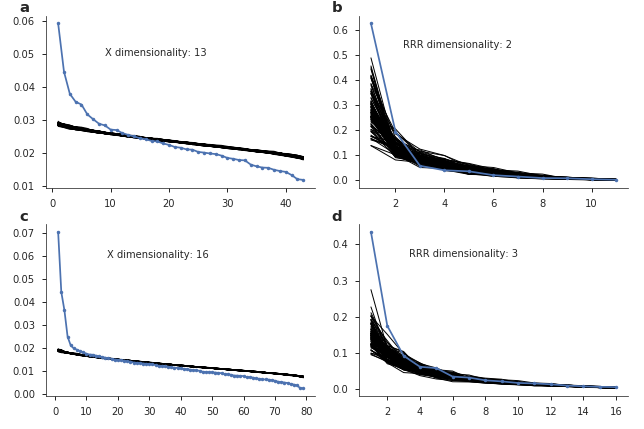

In [40]:
sns_styleset()
plt.figure(figsize=(9,6))
ax = []
for i in range(4):
    ax.append(plt.subplot(2,2,i+1))
           
dimensionality(Xcadwell, Ycadwell, axes=(ax[0], None, ax[1]))
dimensionality(X, Y,               axes=(ax[2], None, ax[3]))
sns.despine()
plt.tight_layout()

plt.text(-.1, 1.02, 'a', transform = plt.gcf().get_axes()[0].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1.02, 'b', transform = plt.gcf().get_axes()[1].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1.02, 'c', transform = plt.gcf().get_axes()[2].transAxes, fontsize=15, fontweight='bold')
plt.text(-.1, 1.02, 'd', transform = plt.gcf().get_axes()[3].transAxes, fontsize=15, fontweight='bold')

plt.savefig('figures/figure-dimensionality.pdf')